# M.1. Solutions

## Markets Foundations

### UChicago Financial Mathematics

#### September 2022

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

# 1. Treasury Debt Composition

## Data

This assignment uses the data file `../data/treasury_quotes_2022-06-30.xlsx`.

## Note

The `ITYPE` column identifies
* 1: bonds
* 2: notes
* 4: bills
* 11: TIPS notes
* 12: TIPS bonds

The column `TDPUBOUT` lists the dollar size of the issue (public debt outstanding.)

The data source does not list the issue size for the T-bills, which is why we are not segmenting those out separately.

*Tip* `.pivot_table()` may be useful.

## 1.1
Plot the total amount of outstanding debt maturing at each date

## 1.2
Plot the amount of outstanding debt maturing at each date, segmented by bonds, notes, TIPS (combined ITYPE of 11 and 12.)

## 1.3
Report the total outstanding debt (summed over all maturity dates,) segmented by bonds, notes, TIPS.

## 1.4
Make a pie chart of this total number (reported in 1.3.) 

# <span style="color:red">Solution 1</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [2]:
QUOTE_DATE = '2022-06-30'

filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

In [3]:
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

In addition to `TDPUBOUT` for total public debt outstanding, 

also try `TDTOTOUT` for total debt outstanding, which also reports bills.

The variable `KEY` below selects which variable is examined.

In [4]:
KEY = 'TDTOTOUT'

## 1.1

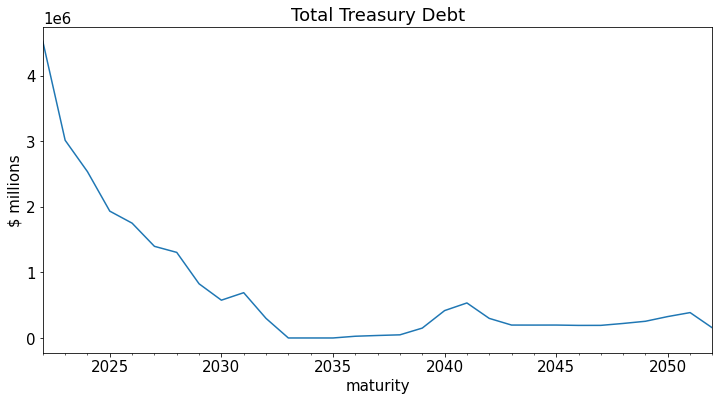

In [5]:
debts = rawdata.pivot_table(values=KEY,index='TMATDT',columns='ITYPE',aggfunc='sum') \
    .resample('Y').sum().rename(columns={1:'bonds',2:'notes',4:'bills'})
debts['TIPS'] = debts[11] + debts[12]
debts.drop(columns=[11,12],inplace=True)

debts.sum(axis=1).plot(title='Total Treasury Debt',ylabel='$ millions',xlabel='maturity');

## 1.2

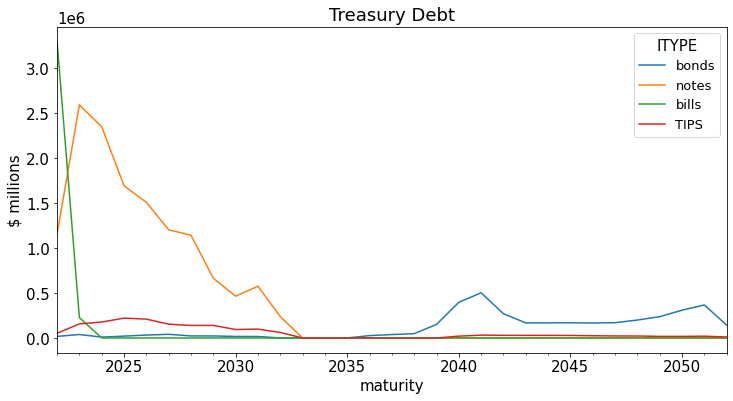

In [6]:
debts.plot(title='Treasury Debt',ylabel='$ millions',xlabel='maturity');

## 1.3

In [7]:
debts.sum().to_frame().rename(columns={0:'debt outstanding ($ millions)'}).style.format('{:,.2f}')

,debt outstanding ($ millions)
ITYPE,
bonds,"3,766,593.00"
notes,"13,583,570.00"
bills,"3,523,925.00"
TIPS,"1,805,994.00"


## 1.4

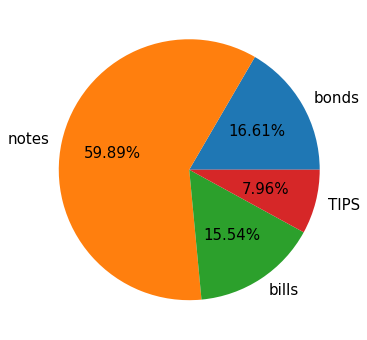

In [8]:
plt.pie(debts.sum().values, labels=debts.columns, autopct='%1.2f%%')
plt.show()

### Not requested, but perhaps interesting to see outstanding via issue

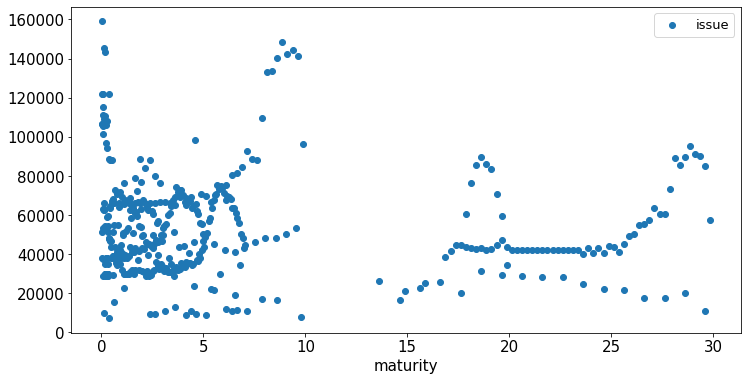

In [9]:
mats = get_maturity_delta(rawdata[['TMATDT']].astype('datetime64[ns]'), t_current=t_current).rename(columns={'TMATDT':'maturity'})

plt.scatter(mats,rawdata[KEY]);
plt.legend(['issue']);
plt.xlabel('maturity');

# 2 Time-to-Maturity

## 2.1

Calculate the time-to-maturity (relative to the quote date of 2022-03-31) for each issue.

Use the `TMATDT` column to get the maturity date.

Report the summary statistics of these time-to-maturities. (Consider using .describe()).

## 2.2
Plot the time-to-maturity against the provided YTM, (column `TDYLD`.)

# <span style="color:red">Solution 2</span>

## 2.1

In [10]:
mats_issues = get_maturity_delta(rawdata['TMATDT'],t_current=t_current)
mats_issues.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
TMATDT,425.0,6.558918,8.173429,0.013689,1.040383,3.170431,6.833676,29.875428


## 2.2

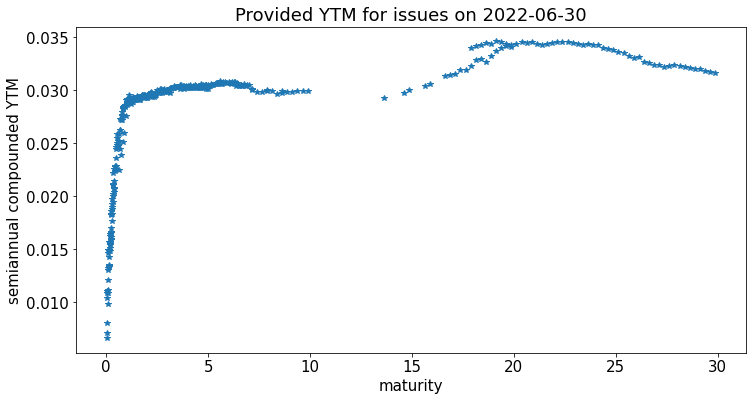

In [11]:
FREQ = 365

plt.plot(mats_issues,rawdata['TDYLD']* FREQ,linestyle='',marker='*')
plt.title(f'Provided YTM for issues on {pd.to_datetime(t_current):%Y-%m-%d}')
plt.ylabel('semiannual compounded YTM')
plt.xlabel('maturity')
plt.show()

# 3 Yields and Prices

## 3.1

For the Treasury bills, calculate the **discount yields**.

Identify the T-bills using `ITYPE`=4 or looking for `TCOUPRT` of 0.

## 3.2

Write a function to calculate the yield-to-maturity for each issue. You will need to use a nonlinear solver to solve for the YTM.

## 3.3
Conceptual question, no outside data needed.

Consider a Treasury with...
* maturity 2 years
* face value 100
* coupon rate 4\%, semiannual
* current yield-to-maturity is 3\%


1. Calculate the price of the treasury.
1. Suppose that both its YTM and coupon rate go up by 0.5\%. What is the revised price of this Treasury?

# <span style="color:red">Solution 3</span>

## 3.1

In [12]:
DAYCT_ADJ = 360/365

tbills = rawdata[rawdata['ITYPE']==4]
px_tbills = tbills[['TDASK','TDBID']].mean(axis=1)
mat_bills = get_maturity_delta(tbills['TMATDT'],t_current=t_current)
disc_yield = ((100-px_tbills)/100 / (mat_bills * DAYCT_ADJ)).to_frame().rename(columns={0:'discount yield'})
disc_yield.style.format('{:.2%}')

,discount yield
KYTREASNO,
207851,0.67%
207817,0.73%
207852,1.13%
207741,1.06%
207853,1.10%
207827,1.13%
207854,1.11%
207828,1.00%
207855,1.14%


In [13]:
disc_yield.describe().T.style.format('{:.2%}')

,count,mean,std,min,25%,50%,75%,max
discount yield,5100.00%,1.77%,0.53%,0.67%,1.37%,1.72%,2.19%,2.76%


## 3.2

We will get a better YTM estimate if we use a price that is...
* the mean of the **bid** (`TDBID`) and **ask** (`TDASK`)
* includes the **accrued interest** (`TDACCINT`)

In [14]:
from scipy.optimize import fsolve

def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

In [15]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [16]:
px = (rawdata[['TDASK','TDBID']].mean(axis=1) + rawdata['TDACCINT']).loc[CF.index]
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)

ytm = pd.Series(index=px.index,dtype=float)
for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond] = fsolve(pv_wrapper,.01)

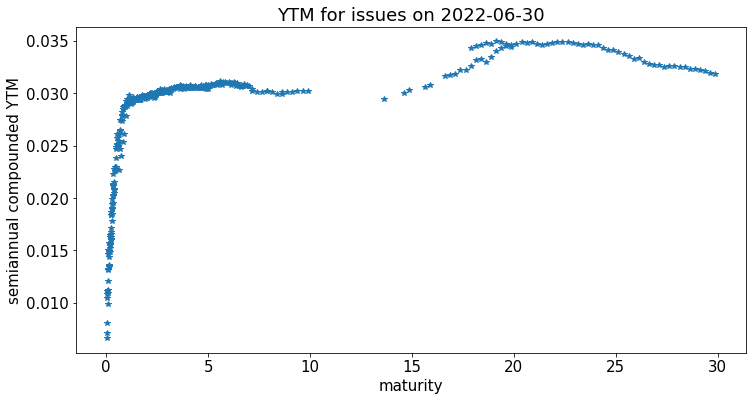

In [17]:
plt.plot(mats_issues.loc[ytm.index],ytm,linestyle='',marker='*')
plt.title(f'YTM for issues on {pd.to_datetime(t_current):%Y-%m-%d}')
plt.ylabel('semiannual compounded YTM')
plt.xlabel('maturity')
plt.show()

### Compare to the provided YTM calcs in the original data source

In [18]:
(rawdata['TDYLD'].loc[CF.index]*FREQ - ytm).describe().to_frame().rename(columns={0:'yield error'}).T.style.format('{:,.4%}')

,count,mean,std,min,25%,50%,75%,max
yield error,"37,600.0000%",-0.0223%,0.0072%,-0.0325%,-0.0256%,-0.0245%,-0.0223%,-0.0016%


## 3.3

In [19]:
rADJ = .005
CFadj = CF + rADJ/2 * 100 * (CF>0)
ytm = rawdata.loc[CF.index,'TDYLD']*365
disc_rates = ytm + rADJ

COMPOUNDING = 2

pxfloat = pd.Series(index=px.index, dtype=float)
pxfixed = pd.Series(index=px.index, dtype=float)

for sec in CF.index:
    disc_adj = intrate_to_discount(disc_rates.loc[sec],maturity_grid,n_compound=COMPOUNDING)
    pxfloat.loc[sec] = (CFadj.loc[sec,:] @ disc_adj.values)#.rename(columns={0:'price adjusted'})
    pxfixed.loc[sec] = (CF.loc[sec,:] @ disc_adj.values)#.rename(columns={0:'price adjusted'})
    

price_comp = pd.concat([px,pxfixed,pxfloat],axis=1,keys=['price','fixed coupon','floating coupon'])

idx = rawdata['TMATDT']<='2027-06-30'
price_comp[idx]

/var/folders/03/w2qjd9795f9_qlz29c6n6s600000gn/T/ipykernel_99768/1017236185.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  price_comp[idx]


,price,fixed coupon,floating coupon
KYTREASNO,,,
207851,99.990903,99.984111,100.234072
207817,99.986292,99.976791,100.226733
207852,99.963500,99.947317,100.197185
207741,99.959944,99.941044,100.190896
207386,100.841549,100.821043,101.070909
...,...,...,...
207094,97.156250,95.087531,97.369845
207887,98.332351,96.227634,98.719226
207546,88.361296,86.381104,88.870172


### The revised price is nearly the exact same!

This illustrates the key point of a floating-rate note (bond):
* The change in interest rate impacts the discount AND the coupon.
* These two effects are *nearly* offsetting.

# 4 Short-Term Rates

Use the data in `data/ref_rates.xlsx` to explore several key rates that are used as benchmarks for floating rates.
* SOFR
* Fed funds
* 3-month T-bill yield

Calculate the correlation between the three rates (filtering to the dates for which they all have reported values.)

Do this correlation analysis for the data in
* levels (as provided)
* differences (day-over-day changes)

# <span style="color:red">Solution 4</span>

In [20]:
filepath = '../data/ref_rates.xlsx'
refs = pd.read_excel(filepath, sheet_name='data').set_index('date')

In [21]:
refs.corr()

,DTB3,DFF,SOFR
DTB3,1.000000,0.988042,0.982199
DFF,0.988042,1.000000,0.994842
SOFR,0.982199,0.994842,1.000000


In [22]:
refs.diff().corr()

,DTB3,DFF,SOFR
DTB3,1.000000,0.158403,0.108907
DFF,0.158403,1.000000,0.305339
SOFR,0.108907,0.305339,1.000000
